In [27]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 3830, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3830 (delta 39), reused 77 (delta 22), pack-reused 3722
Receiving objects: 100% (3830/3830), 673.58 MiB | 25.38 MiB/s, done.
Resolving deltas: 100% (624/624), done.
Checking out files: 100% (2827/2827), done.
/content/STAT3007_Project/STAT3007_Project/STAT3007_Project


In [28]:
pip install colorednoise

In [29]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary


class NoiseColour:
  White = 0
  Violet = -2
  Blue = -1
  Pink = 1
  Brown = 2

def nosify(samples, noise_level = 1, colour = NoiseColour.White):
  if colour == NoiseColour.White:
    noise = torch.randn_like(samples)
  else:
    noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent = colour, size = samples.shape[1])).float()

  scaled_noise = noise * torch.mean(torch.abs(samples)) * noise_level
  
  noisy_samples = samples + scaled_noise
  return noisy_samples

def data_gen(sample, sampling_rate ,duration):
  truncated_sample = truncate_silence(sample)
  truncated_sample = amp_normalisation(truncated_sample)

  total_duration = truncated_sample.shape[0]
  diff_duration = total_duration - (duration * sampling_rate)

  padded_sample = truncated_sample
  if diff_duration < 0:
    padded_sample = pre_pad(truncated_sample, int(duration * sampling_rate))
    
  spectrogram = mel_spectral_decomposition(padded_sample[:int(sampling_rate * duration)], sampling_rate)

  return spectrogram

In [30]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device == torch.device('cuda'))

False


In [31]:
noisy_spectrograms = []
clean_spectrograms = []
for name in glob.glob('/content/STAT3007_Project/sample-noisy-speech-actor-11/*.wav'):

  clean_name = name.split('/')[-1].split('_')[0]
  noisy_samples, noisy_sampling_rate = librosa.load(name, sr = 16000)
  clean_samples, clean_sampling_rate = librosa.load('./Audio_Speech_Actors_01-24/Male/Actor_11/'+clean_name+'.wav', sr = 16000)

  noisy_data = data_gen(noisy_samples, noisy_sampling_rate, 2)
  clean_data = data_gen(clean_samples, clean_sampling_rate,2)

  noisy_spectrograms.append(noisy_data)
  clean_spectrograms.append(clean_data)

In [32]:
print(torch.tensor(noisy_spectrograms).shape)
print(torch.tensor(clean_spectrograms).shape)

torch.Size([790, 128, 63])
torch.Size([790, 128, 63])


In [33]:
X = torch.tensor(noisy_spectrograms)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
y = torch.tensor(clean_spectrograms)

In [34]:
# Autoencoder with optimal hyper-parameters already put in
class Encoder(nn.Module):
  def __init__(self, filters = 8):
    super(Encoder, self).__init__()
    (K, S) = (5, 1)
    self.conv = nn.Sequential(nn.Conv2d(1, filters, kernel_size= (3,4), stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.ReLU(),
                              nn.Conv2d(filters,filters,kernel_size= (3,4), stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(filters,filters,kernel_size= (3,4), stride = 1),
                              nn.ReLU()
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x


class Decoder(nn.Module):
  def __init__(self, filters = 8):
    super(Decoder, self).__init__()
    (K, S) = (2, 1)
    self.conv = nn.Sequential(nn.ConvTranspose2d(filters,filters, kernel_size = (3,4)),
                              nn.ReLU(),
                              nn.Upsample(size = (61,27)),
                              nn.ConvTranspose2d(filters,filters, kernel_size = (3,4)),
                              nn.ReLU(),
                              nn.Upsample(size = (126,60)),
                              nn.ConvTranspose2d(filters,1, kernel_size = (3,4)),
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x

class Autoencoder(nn.Module):
  def __init__(self, filters):
    super(Autoencoder,self).__init__()
    self.filters = filters
    self.encoder = Encoder(filters)
    self.decoder = Decoder(filters)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [35]:
test_encoder = Encoder()
test_decoder = Decoder()
# if cuda gps available: 
if device == torch.device('cuda'):
    test_ae = Autoencoder(8).cuda()
else:
    test_ae = Autoencoder(8)
summary(test_ae,(1,128,63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 126, 60]             104
              ReLU-2           [-1, 8, 126, 60]               0
         MaxPool2d-3            [-1, 8, 63, 30]               0
              ReLU-4            [-1, 8, 63, 30]               0
            Conv2d-5            [-1, 8, 61, 27]             776
              ReLU-6            [-1, 8, 61, 27]               0
         MaxPool2d-7            [-1, 8, 30, 13]               0
            Conv2d-8            [-1, 8, 28, 10]             776
              ReLU-9            [-1, 8, 28, 10]               0
          Encoder-10            [-1, 8, 28, 10]               0
  ConvTranspose2d-11            [-1, 8, 30, 13]             776
             ReLU-12            [-1, 8, 30, 13]               0
         Upsample-13            [-1, 8, 61, 27]               0
  ConvTranspose2d-14            [-1, 8,

In [36]:
class DatasetWrapper(Dataset):
  def __init__(self, X, y):
    self.X, self.y = X, y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
  def change_type(self, dtype):

    return DatasetWrapper(self.X.type(dtype),self.y.type(dtype))
  
  def dataset(self):
    return DatasetWrapper(self.X,self.y)
  
  def get_data(self):
    return self.X, self.y
def train_model(data, net, loss, nepoch ,lr = 0.01, batch_size = -1, use_cuda = False, print_output = True):
  
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  optimizer = optim.Adam(net.parameters(), lr = lr)
  data = data.dataset.change_type(dtype)

  if batch_size == -1:
    data_loader = DataLoader(data,
                         batch_size = data.dataset__len__, shuffle = True)
  
  else:
    data_loader = DataLoader(data,
                             batch_size = batch_size, shuffle = True)

  losses_log = []

  for epoch in range(nepoch):
     total_loss = 0
     batch_count = 0
     for X_batch, y_batch in data_loader:
      batch_count += 1
      y_batch = y_batch.reshape(y_batch.shape[0],1,y_batch.shape[1],y_batch.shape[2])
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive
      pred = net(X_batch)

      Rn = loss(pred[:,0,:,:], y_batch[:,0,:,:])
      Rn.backward()
      optimizer.step()
      total_loss += Rn

     if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
     
     losses_log.append(total_loss / batch_count)

  print('final loss:', Rn.item())
  
  return net

In [37]:
spectro_data = DatasetWrapper(X,y)
train_size = int(X.shape[0] * 0.7)
test_size = X.shape[0] - train_size

loss = nn.MSELoss()

data_test, data_train = random_split(spectro_data,[test_size,train_size], generator = torch.Generator().manual_seed(10))
nepoch = 100
batch_size = 30

torch.manual_seed(69)
AE = Autoencoder(8)

trained_net = train_model(data_train,AE, loss, nepoch = nepoch,lr = 0.01, batch_size = batch_size, use_cuda = True,print_output = True)

epoch: 0
loss: 269.2278747558594
------------
epoch: 1
loss: 170.45001220703125
------------
epoch: 2
loss: 150.33265686035156
------------
epoch: 3
loss: 143.03135681152344
------------
epoch: 4
loss: 148.15582275390625
------------
epoch: 5
loss: 107.84280395507812
------------
epoch: 6
loss: 120.71839904785156
------------
epoch: 7
loss: 118.24026489257812
------------
epoch: 8
loss: 133.36033630371094
------------
epoch: 9
loss: 135.62059020996094
------------
epoch: 10
loss: 137.55233764648438
------------
epoch: 11
loss: 123.53836822509766
------------
epoch: 12
loss: 127.00550842285156
------------
epoch: 13
loss: 112.88256072998047
------------
epoch: 14
loss: 121.47957611083984
------------
epoch: 15
loss: 107.57300567626953
------------
epoch: 16
loss: 104.42384338378906
------------
epoch: 17
loss: 104.09718322753906
------------
epoch: 18
loss: 127.76792907714844
------------
epoch: 19
loss: 91.79410552978516
------------
epoch: 20
loss: 113.05952453613281
------------
epoc

<class '__main__.Autoencoder'>


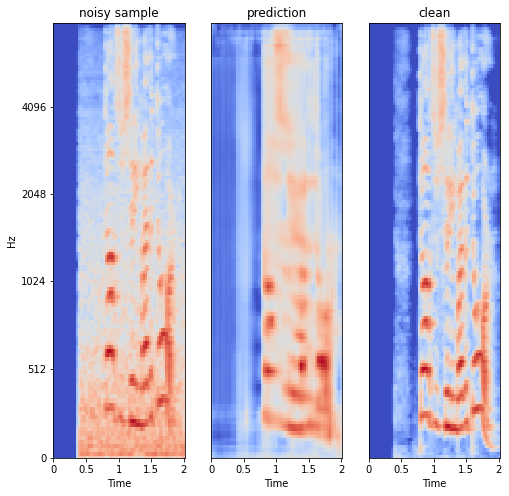

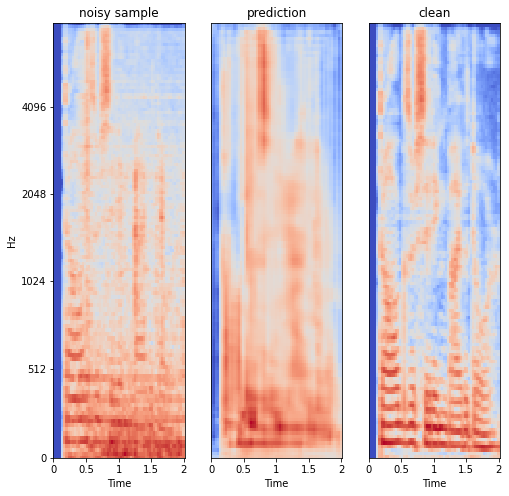

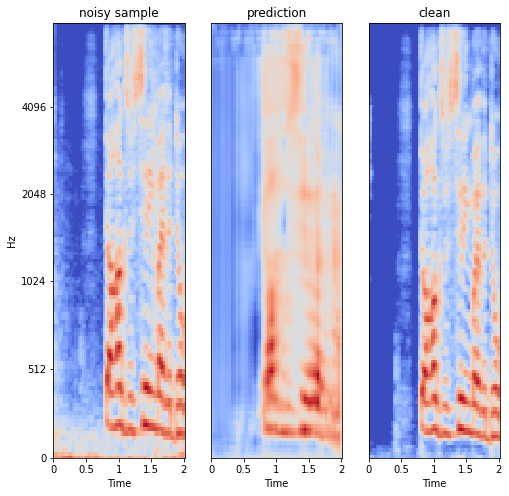

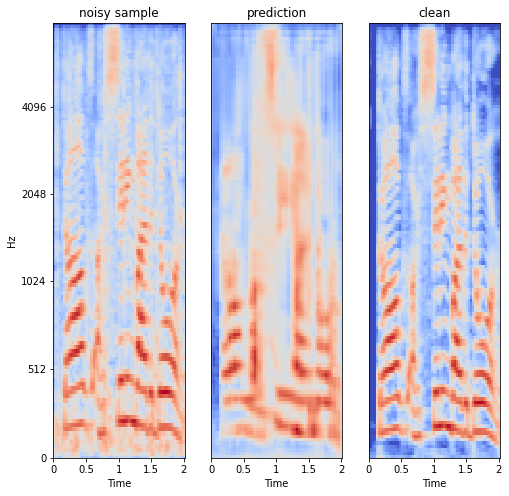

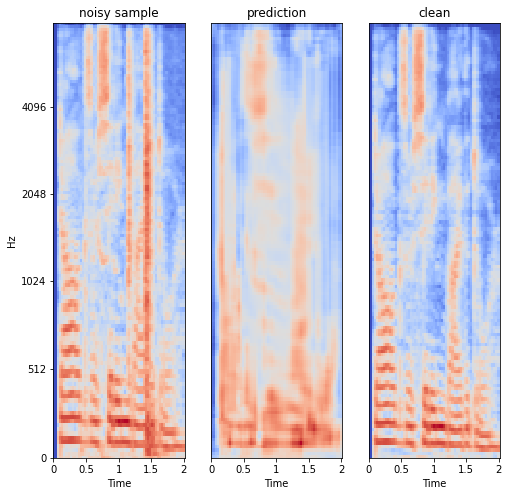

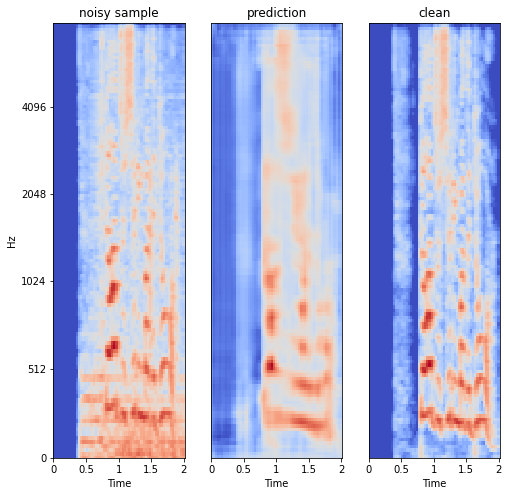

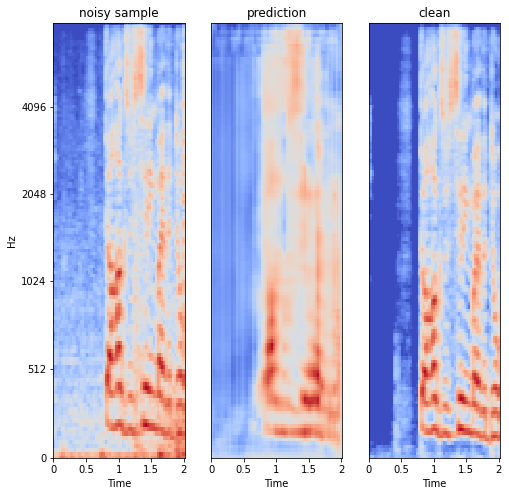

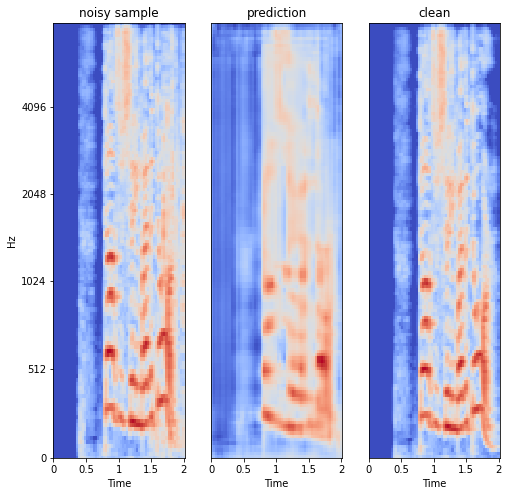

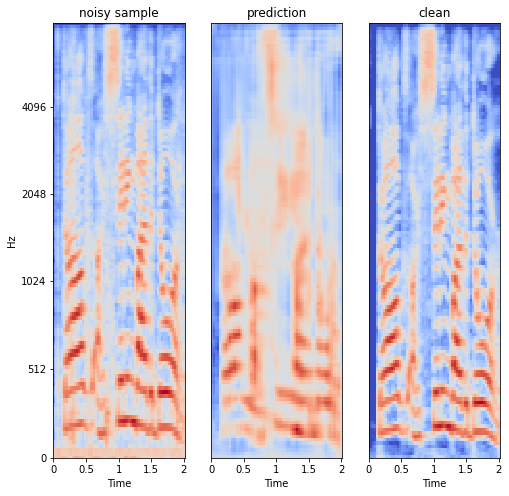

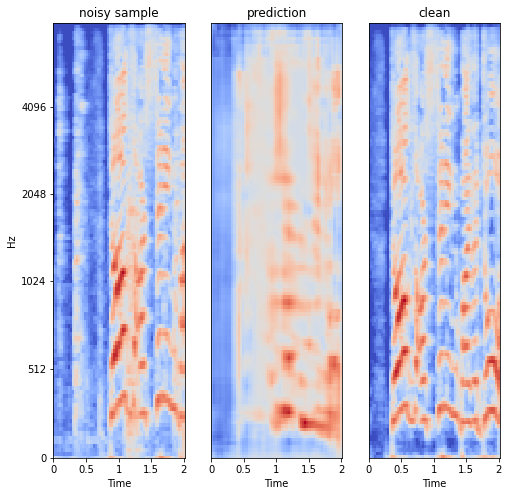

In [38]:
X_test, y_test = data_test.dataset.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    trained_net = trained_net.to(torch.device('cpu'))
print(type(trained_net))
y_pred = trained_net(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

# I will train with all the noisy data on the drive